# Bioinformatics 1
## Assignment 2
### Question 3

In [2]:
# do not copy these lines if you use python/ipython
# this is only used to plot in ipython notebooks
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# import required Biophython functions 
from Bio import Entrez
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio import SubsMat

### first obtain the sequence identifier for your chosen gene from the NCBI database
Note here we work with protein sequences, so make sure you get the protein entry:
go to 'Reference Sequence'  and choose the entry beginning with NP_

In [4]:
Entrez.email = 'A.N.Other@example.com'

my_protein = 'NP_002102.4'  # huntingtin [Homo sapiens]

handle = Entrez.efetch(db="nucleotide", id=my_protein, rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
handle.close()

In [5]:
# show the sequence record
# here we have choosen the human Thy1 gene
print(record)

ID: NP_002102.4
Name: NP_002102
Description: huntingtin [Homo sapiens].
Number of features: 48
/organism=Homo sapiens
/taxonomy=['Eukaryota', 'Metazoa', 'Chordata', 'Craniata', 'Vertebrata', 'Euteleostomi', 'Mammalia', 'Eutheria', 'Euarchontoglires', 'Primates', 'Haplorrhini', 'Catarrhini', 'Hominidae', 'Homo']
/sequence_version=4
/data_file_division=PRI
/db_source=REFSEQ: accession NM_002111.8
/date=19-JUL-2016
/keywords=['RefSeq']
/accessions=['NP_002102']
/structured_comment=defaultdict(<class 'dict'>, {'RefSeq-Attributes': {'regulatory uORF': 'PMID: 12466534'}, 'Evidence-Data': {'Transcript exon combination': 'AB016794.1, L12392.1 [ECO:0000332]', 'RNAseq introns': 'single sample supports all introns'}})
/topology=linear
/source=Homo sapiens (human)
/references=[Reference(title='Cytoplasmic Ubiquitin-Specific Protease 19 (USP19) Modulates Aggregation of Polyglutamine-Expanded Ataxin-3 and Huntingtin through the HSP90 Chaperone', ...), Reference(title='Cholesterol Modifies Huntingtin

In [6]:
# run a BLAST via the web
result_handle = NCBIWWW.qblast('blastp', 'swissprot', record.seq)
# parse the results
blast_record = NCBIXML.read(result_handle)  # This takes some time to run

In [7]:
# show all matches returned with names 
a=blast_record.alignments
for aa in a:
    print(aa.title.split('|')[4].split(' ')[0],)
    for h in aa.hsps:
        print(h.expect)

HD_HUMAN
0.0
HD_MOUSE
0.0
HD_RAT
0.0
HD_TAKRU
0.0
HD_DICDI
5.92424e-19
4.14712e-18
9.97958e-12
1.70443e-09
6.11751e-08
0.0650016
4.44578


Inspect your results. Which of them are sensible?

In [8]:
# print all results with e-value below this value:
E_VALUE_THRESH = 1e-6
# lower this threshold to also see sequences with poor match

# now print, for each match:

# name of alignment
# length of alignment
# e-value
# Query sequence
# Matching sequence
# Alignment info

for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        if hsp.expect < E_VALUE_THRESH:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            print('e value:', hsp.expect)
            print(hsp.query[0:75] + '...')
            print(hsp.sbjct[0:75] + '...')
            print(hsp.match[0:75] + '...')


****Alignment****
sequence: gi|296434520|sp|P42858.2|HD_HUMAN RecName: Full=Huntingtin; AltName: Full=Huntington disease protein; Short=HD protein
length: 3142
e value: 0.0
MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQQQPPPPPPPPPPPQLPQPPPQAQPLLPQPQPPPPPPP...
MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQ--PPPPPPPPPPPQLPQPPPQAQPLLPQPQPPPPPPP...
MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQ  PPPPPPPPPPPQLPQPPPQAQPLLPQPQPPPPPPP...
****Alignment****
sequence: gi|1708161|sp|P42859.2|HD_MOUSE RecName: Full=Huntingtin; AltName: Full=Huntington disease protein homolog; Short=HD protein homolog
length: 3119
e value: 0.0
AEEPLHRPKKELSATKKDRVNHCLTICENIVAQSVRNSPEFQKLLGIAMELFLLCSDDAESDVRMVADECLNKVI...
AEEPLHRPKKELSATKKDRVNHCLTICENIVAQSLRNSPEFQKLLGIAMELFLLCSNDAESDVRMVADECLNKVI...
AEEPLHRPKKELSATKKDRVNHCLTICENIVAQS+RNSPEFQKLLGIAMELFLLCS+DAESDVRMVADECLNKVI...
****Alignment****
sequence: gi|1708162|sp|P51111.1|HD_RAT RecName: Full=Huntingtin; AltName: Full=Huntington disease protein homolog; Short=HD protein homolog
length:

In [9]:
# now work with all results with e-value below this value:
E_VALUE_THRESH = 1e-6

def get_seqrecs(alignments, threshold):
    # a little helper function to get the sequence records
    for aln in alignments:
        for hsp in aln.hsps:
            if hsp.expect < threshold:
                id = aln.title.split('|')[4].split(' ')[0]
                #id = aln.accession
                print(id)
                yield SeqRecord(Seq(hsp.sbjct), id=id)#,description=str(aln.title.split('|')[4]))
                break
 
best_seqs = get_seqrecs(blast_record.alignments, E_VALUE_THRESH)
# write out to a fasta file
SeqIO.write(best_seqs, 'family_alignment.fasta', 'fasta')

HD_HUMAN
HD_MOUSE
HD_RAT
HD_TAKRU
HD_DICDI


5

In [10]:
# run Muscle MSA
cmdline = MuscleCommandline('./muscle3.8.31_i86linux64',input='family_alignment.fasta', 
                            out='family_alignment.aln', clw=True)
cmdline()

('',
 '\nMUSCLE v3.8.31 by Robert C. Edgar\n\nhttp://www.drive5.com/muscle\nThis software is donated to the public domain.\nPlease cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.\n\nfamily_alignment 5 seqs, max length 3144, avg  length 2533\n00:00:00    10 MB(-2%)  Iter   1    6.67%  K-mer dist pass 1\n00:00:00    10 MB(-2%)  Iter   1  100.00%  K-mer dist pass 1\n00:00:00    10 MB(-2%)  Iter   1    6.67%  K-mer dist pass 2\n00:00:00    10 MB(-2%)  Iter   1  100.00%  K-mer dist pass 2\n00:00:00    14 MB(-3%)  Iter   1   25.00%  Align node       \n00:00:00    32 MB(-6%)  Iter   1   50.00%  Align node\n00:00:01    33 MB(-6%)  Iter   1   75.00%  Align node\n00:00:01    34 MB(-7%)  Iter   1  100.00%  Align node\n00:00:01    35 MB(-7%)  Iter   1  100.00%  Align node\n00:00:01    35 MB(-7%)  Iter   1   20.00%  Root alignment\n00:00:01    35 MB(-7%)  Iter   1   40.00%  Root alignment\n00:00:01    35 MB(-7%)  Iter   1   60.00%  Root alignment\n00:00:01    35 MB(-7%)  Iter   1   80.00%  Root

In [11]:

alignment = AlignIO.read('family_alignment.aln','clustal')
print(alignment)


SingleLetterAlphabet() alignment with 5 rows and 3224 columns
--------------------------------------------...--- HD_DICDI
MATMEKLMKAFESLKSFQQQQ-----------------------...--- HD_TAKRU
MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPP...TTC HD_HUMAN
--------------------------------------------...TTC HD_MOUSE
--------------------------------------------...TAC HD_RAT


In [12]:
summary_align = AlignInfo.SummaryInfo(alignment)

# compute a consensus sequence by taking the most frequent letter
# positions below a thresold similarity are shown as 'X'
# threshold can be adjusted by adding e.g. threshold=0.5
print('Consensus sequence without gaps:')
print(summary_align.dumb_consensus())
print('Consensus sequence with gaps:')
print(summary_align.gap_consensus())
print('Consensus sequence with gaps and different threshold:')
print(summary_align.gap_consensus(threshold=0.05))

Consensus sequence without gaps:
MATXEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPPPPPQLPQPPPQAQPLLPQPQPPPPPPPPPPGPXXAEEPLHRPKKELSATKKDRVNHCLTICENIVAQSXRXSPEFQKLLGIAMELFLLCSDDAESDVRMVADECLNKVIKALMDSNLPRLQLELYKEIKKNGAPRSLRAALWRFAELAHLVRPQKCRPYLVNLLPCLTRTSKRPEESVQETLAAAVPKIMASFGNFANDNEIKVLLKAFIANLKSSSPTXRRTAAGSAVSICQHSRRTXYFYXWLLNVLLGLLVPXEEEHXTLLILGVLLTLRXLVPLLQQQVKDTSLKGSFGVTRKEMEVSPSXEQLVQVYELTLHHTQHQDHNVVTGALELLQQLFRTPPPELLQXLTTXGGXGQLTXXXEEXXGRXRSGSIVELXAGGGSSCSPXLXRKQKGKVLLGEEEALEDDSESRSDVSSSAFXASVKXEIXGELAASSSGVSTPGSXGHDIITEQPRSSQHTLQPADSVDLSXCDLTSXATDGASASDTPESPNDEEDILSHSSSCGANITPETQXSAVPSDPAMDGRPVGLNDGTQASSPISDSSQTTTEGPDSAVTPSDSSEIVLDGXDSQYLGXQIGQPQXEDXEGAAGXLXXEXSDXFRNSSLALQQAHLLEXMGHXRQPSDSSVDKFVXXDEXXEXXDPEXKPCRIKGDIGQXXDDDSAPLVHCVRLLSASFLLTGXKXXLVPDRDVRVSVKALALSCXGAAVALHPEXFFXXLYKVPLXTXEXXEEQYXSDILNYIDHGDPQVRGATAILCGTLXXSILSRSRXXVGDWLGXIRXLTGNTFSLVDCIPLLQKTLKDESSVTCKLACTAVRHCVXSLCSSSYSXLGLQLXIDXLXLKNSSYWLVRTELLETLAEIDFRLVSFLEAKAEXLHRGXHHYTGXLKLQERVLNNVVIXLLGDEDPRVRHVAAXXLXRLVPKL

In [13]:
# print a Position Specific Score Matrix (PSSM)
# this shows the number of letters counted at each location
# in the sequence, which is shown in vertical along the left
pssm = summary_align.pos_specific_score_matrix(summary_align.dumb_consensus(), chars_to_ignore = ['X'])
print(pssm)

    -   A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y
M  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
A  3.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
T  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0
X  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
E  3.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
K  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
L  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
M  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
K  3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
A  3.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
F  3.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0

In [14]:
# How to construct a substitution matrix from the alignment
summary_align = AlignInfo.SummaryInfo(alignment)
# done here only for charged amino acids
replace_info = summary_align.replacement_dictionary(["G", "A", "V", "L", "I", "M", "P", "F",
                                                     "W", "S", "T", "N", "Q", "Y", "C"])
my_arm = SubsMat.SeqMat(replace_info)
my_lom = SubsMat.make_log_odds_matrix(my_arm)
my_lom.print_mat()

# you notice that in this example many entries are not defined
# this is because the alignment is too short and does not have all combinations

# you can use a different gene, and/or reduce the e-value threshold to include more data

-   0
D   0   2
E   0  -1   1
H   0  -5  -6   2
K   0  -3  -4  -4   2
R   0  -5  -4  -3  -1   2
   -   D   E   H   K   R


## Phylogenetic trees

In [15]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
#from TreeConstruction import DistanceCalculator
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print(dm)

HD_DICDI	0
HD_TAKRU	0.9438585607940446	0
HD_HUMAN	0.94075682382134	0.3058312655086849	0
HD_MOUSE	0.9159429280397022	0.3055210918114144	0.1088709677419355	0
HD_RAT	0.9165632754342432	0.3073821339950372	0.11228287841191065	0.028225806451612878	0
	HD_DICDI	HD_TAKRU	HD_HUMAN	HD_MOUSE	HD_RAT


In [16]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
#from TreeConstruction import DistanceTreeConstructor
# here supply the keyword upgma or nj
# compare the trees you get from both methods
constructor = DistanceTreeConstructor(calculator, 'upgma')
tree = constructor.build_tree(alignment)
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner4')
        Clade(branch_length=0.31502016129032256, name='Inner3')
            Clade(branch_length=0.09778225806451615, name='Inner2')
                Clade(branch_length=0.0411755583126551, name='Inner1')
                    Clade(branch_length=0.014112903225806439, name='HD_RAT')
                    Clade(branch_length=0.014112903225806439, name='HD_MOUSE')
                Clade(branch_length=0.055288461538461536, name='HD_HUMAN')
            Clade(branch_length=0.1530707196029777, name='HD_TAKRU')
        Clade(branch_length=0.46809088089330025, name='HD_DICDI')


                                                                   __ HD_RAT
                                                             _____|
                                               _____________|     |__ HD_MOUSE
                                              |             |
  ____________________________________________|             |________ HD_HUMAN
 |                                            |
_|                                            |______________________ HD_TAKRU
 |
 |___________________________________________________________________ HD_DICDI



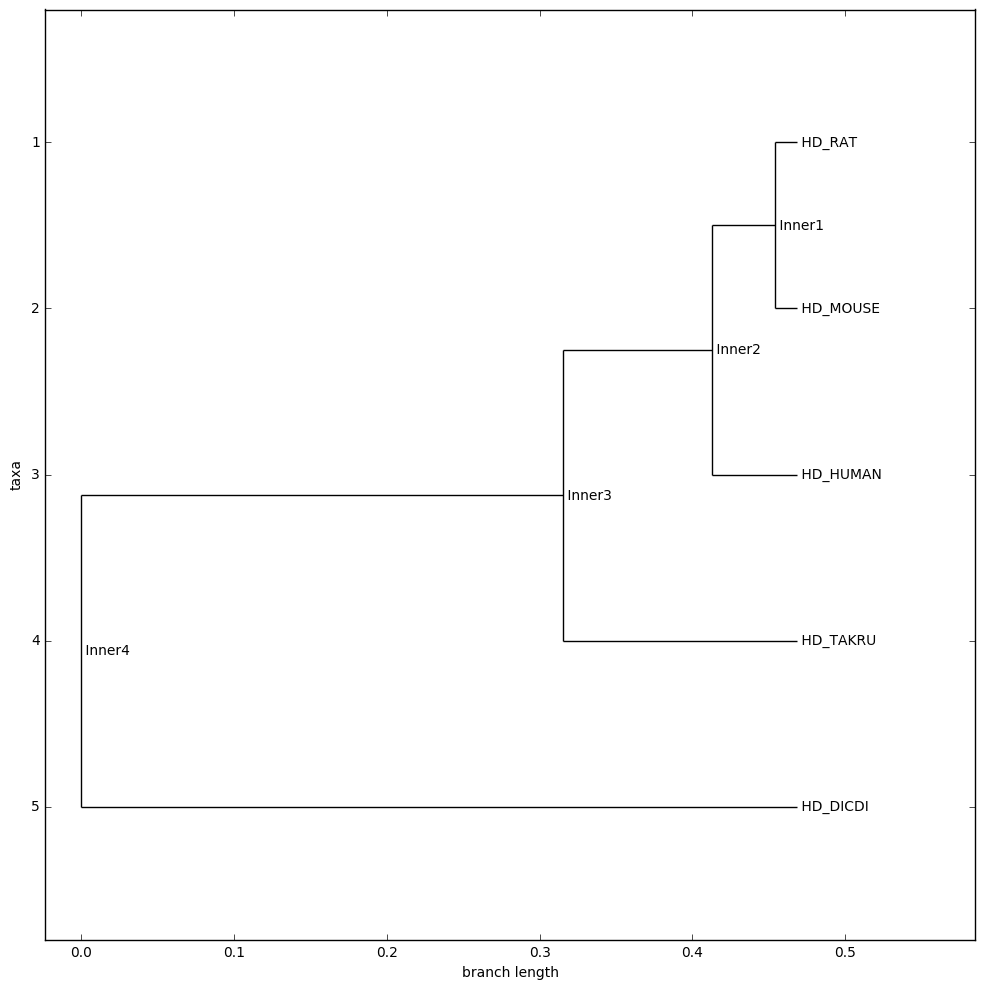

In [17]:
from Bio import Phylo
# now draw the tree, try out these three methods:
Phylo.draw_ascii(tree)
plt.figure(figsize=(12,12))
ax=plt.subplot(111)
Phylo.draw(tree,axes=ax)
# to use this, you need to have the package networkx installed:
#Phylo.draw_graphviz(tree)
